# OPTIVER - TRADING AT THE CLOSE

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
import seaborn as sns

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn import metrics
%matplotlib inline

2024-01-15 18:16:33.703371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Insert Data + Read Data

In [2]:
df = pd.read_csv('train.csv')
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [3]:
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,1,0,0,-5.519986
2,2,0,0,-8.389950
3,3,0,0,-4.010200
4,4,0,0,-7.349849
...,...,...,...,...
5237975,195,480,540,2.310276
5237976,196,480,540,-8.220077
5237977,197,480,540,1.169443
5237978,198,480,540,-1.540184


## Target before training

<Axes: >

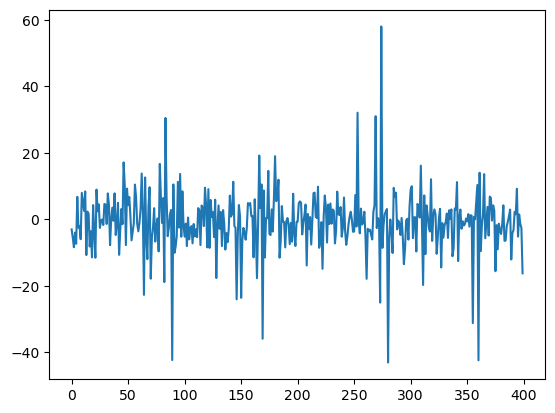

In [4]:
df.head(400)['target'].plot()

## Configuration Parameters 

In [5]:
SEED = 42

N_LAGS = 55 # number of time lags used in the time series analysis.

BATCH_SIZE = 32
BUFFER_SIZE = 100000 # used for shuffling the data during training
EPOCHS = 100
PATIENCE = 25 # used as a parameter in early stopping
LEARNING_RATE = 1e-4

SPLIT_DAY = 390 # day on which the dataset is split into training and validation sets. 

# parameters define the size of the dataset, specifying the number of stocks, dates, and seconds
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

RUN_TRAINING = True # A boolean flag indicating whether to run the training process. If set to True, the model training code will be executed.

## Create Index Combinations

In [6]:
# creating a lists of unique identifiers for stocks, dates, and seconds

all_stock_ids = range(N_STOCKS) # generates stock IDs
all_date_ids = range(N_DATES) # generates date IDs
all_seconds = [i * 10 for i in range(N_SECONDS)] # generates seconds in increments of 10

## Create MultiIndex

In [7]:
# generateing all possible combinations of stock IDs, date IDs, and seconds, creating a hierarchical index

multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

## Update DataFrame

In [8]:
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index) # reindex method is used to align the DataFrame with the new MultiIndex created 

missing_values_count = df_full.isnull().sum()
print(missing_values_count)

target    53108
dtype: int64


## Fixing null values

In [9]:
df_full = df_full.fillna(0) # Filling with 0
df_full = df_full.reset_index()

missing_values_count = df_full.isnull().sum()
print(missing_values_count)


stock_id             0
date_id              0
seconds_in_bucket    0
target               0
dtype: int64


## Assertion Check

In [10]:
assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS) # ensures that the resulting DataFrame has the expected number of rows, which should be the product of the specified numbers of stocks, dates, and seconds
df_full

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


## HeatMap for Visualization Correlations

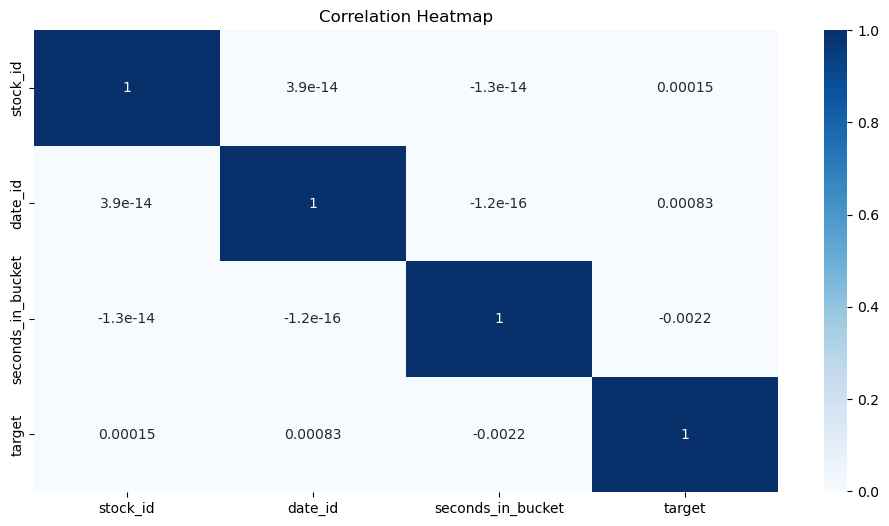

In [11]:
selected_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
selected_data = df_full[selected_columns]

plt.figure(figsize=(12,6))

sns.heatmap(selected_data.corr(), cmap="Blues", annot=True) #Dropping the first column bc it is date 
plt.title('Correlation Heatmap')
plt.show()

 ## Preparing Time-Series Data for Training Machine learning models for LSTM

In [12]:
# Define a function for preparing time-series data as windowed input-output pairs

def windowed_dataset(dataset, shuffle=True):
    
    # Convert the input dataset into a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    
    # Create overlapping windows of size (N_LAGS + 1) with a shift of 1 and drop incomplete windows
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset of windows into a dataset of sequences with size (N_LAGS + 1)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    
    # Create input-output pairs by mapping each sequence to a tuple (input, output)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Optionally shuffle the dataset to avoid learning patterns based on the order of examples
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Batch the dataset into batches of size BATCH_SIZE
    # Prefetch one batch to improve training performance by overlapping data loading with training
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    
    # Return the final prepared dataset
    return dataset

## Transforming df into a Pivoted DataFrame Suitable for Time-Series Analysis

In [13]:
def build_features(df):
    # Define ranges for stock_ids and seconds_in_bucket
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    # Create a MultiIndex with all combinations of stock_ids, date_ids, and seconds_in_bucket
    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])

    # Set the MultiIndex on the DataFrame and reindex to fill missing values with 0
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)

    # Reset the index to bring the MultiIndex levels back to columns
    df_full = df_full.reset_index()

    # Pivot the DataFrame to create a table with stock_ids as columns and hierarchical indices
    df_pivoted = df_full.pivot_table(
        values='target', 
        index=['date_id', 'seconds_in_bucket'], 
        columns='stock_id')

    # Reset the index to make date_id and seconds_in_bucket regular columns
    df_pivoted = df_pivoted.reset_index(drop=True)

    # Remove the column name from the MultiIndex levels
    df_pivoted.columns.name = None

    # Return the pivoted DataFrame
    return df_pivoted

build_features(df_full)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010200,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,...,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280209,-8.010268,-0.780225,-0.640154,...,4.210472,2.599955,-15.599728,-1.749992,-9.030104,-1.320243,-3.259778,-4.410148,-1.419783,0.000000
2,4.220009,-6.459951,-6.380081,-2.030134,-0.690222,1.009703,2.930164,-12.069941,-4.119873,-3.250241,...,5.379915,-5.970001,-12.710094,2.160072,-9.999871,5.890131,-0.029802,-6.819964,2.599955,0.000000
3,5.450249,-5.149841,-5.819797,1.130104,-2.589822,-3.089905,0.560284,-6.909967,-1.090169,-6.759763,...,-3.269911,1.300573,-16.660095,4.090071,-9.340048,7.020235,1.549721,1.690388,3.010035,0.000000
4,3.169775,-6.750226,-0.280142,-2.350211,-4.900098,-2.070069,2.199411,-1.209974,-3.100038,-8.199811,...,-2.009869,-0.969768,-9.229779,5.700588,-11.489987,4.500151,-1.350045,-1.929998,4.669428,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,3.999472,2.850294,-4.450083,1.720190,1.939535,-4.569888,-0.630021,-1.729727,-0.680089,3.540516,...,-4.730225,-7.420182,2.959967,-2.359748,-0.650287,3.190041,-1.659989,-0.690222,-2.700090,-7.209778
26451,3.190041,3.169775,-5.559921,4.669428,2.139807,1.679659,-0.360012,-3.240108,2.609491,1.679659,...,-3.340244,-3.479719,1.419783,-1.069903,2.319813,3.770590,-3.039837,-3.299713,-2.070069,-9.750128
26452,-0.169873,5.689859,-5.310178,5.639792,1.660585,2.110004,-1.000166,-4.529953,5.409718,0.350475,...,-1.549721,-1.289845,-0.140071,-1.929998,4.609823,1.449585,-6.319881,-1.999736,-2.239943,3.629923
26453,3.110170,10.650158,-5.239844,5.229711,0.300407,-2.030134,-1.180172,-1.310110,3.240108,0.220537,...,-1.440048,-0.299811,-2.120137,-1.350045,3.110170,4.019737,-7.349849,-3.259778,-3.160238,4.760027


## Creating Model

In [14]:
def build_lstm_model(input_shape):
    model = Sequential()

    # Add an input layer with the specified input shape
    model.add(Input(shape=(N_LAGS, N_STOCKS)))

    # Add the first LSTM layer with 50 units, returning sequences, and the specified input shape
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))

    # Add a dropout layer with a dropout rate of 0.2 to prevent overfitting
    model.add(Dropout(0.2))

    # Add the second LSTM layer with 50 units and returning sequences
    model.add(LSTM(units=50, return_sequences=True))

    # Add a dropout layer with a dropout rate of 0.2
    model.add(Dropout(0.2))

    # Add the third LSTM layer with 50 units
    model.add(LSTM(units=50))

    # Add a dropout layer with a dropout rate of 0.2
    model.add(Dropout(0.2))

    # Add a dense output layer with N_stocks unit for predicting the next closing value
    model.add(Dense(units=N_STOCKS))

    # Compile the model with Mean Absolute Error (MAE) loss and Adam optimizer
    model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model


Epoch 1/100
671/671 [==============================] - 59s 67ms/step - loss: 0.7208 - val_loss: 0.6811
Epoch 2/100
671/671 [==============================] - 55s 74ms/step - loss: 0.7188 - val_loss: 0.6801
Epoch 3/100
671/671 [==============================] - 53s 69ms/step - loss: 0.7153 - val_loss: 0.6784
Epoch 4/100
671/671 [==============================] - 52s 69ms/step - loss: 0.7073 - val_loss: 0.6732
Epoch 5/100
671/671 [==============================] - 58s 78ms/step - loss: 0.7002 - val_loss: 0.6707
Epoch 6/100
671/671 [==============================] - 56s 75ms/step - loss: 0.6977 - val_loss: 0.6702
Epoch 7/100
671/671 [==============================] - 51s 67ms/step - loss: 0.6961 - val_loss: 0.6701
Epoch 8/100
671/671 [==============================] - 55s 73ms/step - loss: 0.6946 - val_loss: 0.6700
Epoch 9/100
671/671 [==============================] - 52s 70ms/step - loss: 0.6935 - val_loss: 0.6701
Epoch 10/100
671/671 [==============================] - 55s 71ms/step - l

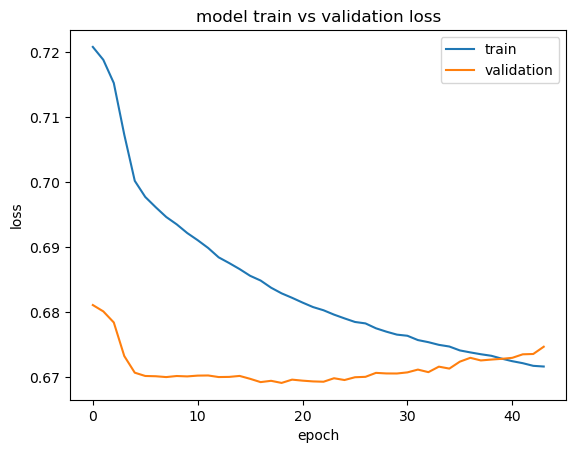

CPU times: user 1h 37min 23s, sys: 28min 1s, total: 2h 5min 24s
Wall time: 43min 52s


In [17]:
%%time 
if RUN_TRAINING:
    # Split the data into training and validation sets based on the specified SPLIT_DAY
    split = df_full['date_id'] > SPLIT_DAY
    df_train = df_full[~split]
    df_valid = df_full[split]

    # Build features for both training and validation sets
    df_train_features = build_features(df_train)
    df_valid_features = build_features(df_valid)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)

    # Create windowed datasets for training and validation
    train_dataset = windowed_dataset(train_features)
    valid_dataset = windowed_dataset(valid_features, shuffle=False)

    # Build an LSTM model with the specified input shape
    lstm_model = build_lstm_model(input_shape=(train_features.shape[1], 1))

    # Define early stopping to monitor validation loss and prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=True
    )

    # Train the LSTM model on the training dataset
    history = lstm_model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=True
    )

    ## Evaluate ## 
    # Predict on the validation dataset
    y_train_pred = lstm_model.predict(train_dataset)
    y_test_pred = lstm_model.predict(valid_dataset)

    # Inverse transform the predictions to the original scale using the scaler
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    # Extract true values from the original validation features
    y_train_true = df_train_features[N_LAGS:]
    y_test_true = df_valid_features[N_LAGS:]

    # Calculate Mean Absolute Error (MAE) as an evaluation metric
    mae = mean_absolute_error(y_train_true, y_train_pred)
    print(f"MAE train score: {mae}")
    mae = mean_absolute_error(y_test_true, y_test_pred)
    print(f"MAE test score: {mae}")

    ## Plots ##
    # Plot the training and validation loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


## Training Metrics

In [30]:
dframe_train = pd.DataFrame({'Actual': y_train_true.values.flatten(), 'Predicted': y_train_pred.flatten()})
dframe_train

,Actual,Predicted
0,-14.089942,0.841720
1,7.330179,0.204658
2,-2.710223,0.586736
3,-6.669760,0.771648
4,0.929832,-0.046907
...,...,...
4289995,-11.060238,4.089047
4289996,-0.669956,2.708541
4289997,-8.400083,-0.813638
4289998,9.839535,2.422198


In [31]:
print('Training:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train_true, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train_true, y_train_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_train_true, y_train_pred)))

Training:
Mean Absolute Error: 6.6886910258369605
Mean Squared Error: 94.99016124276436
Root Mean Square Error: 9.746289614143649


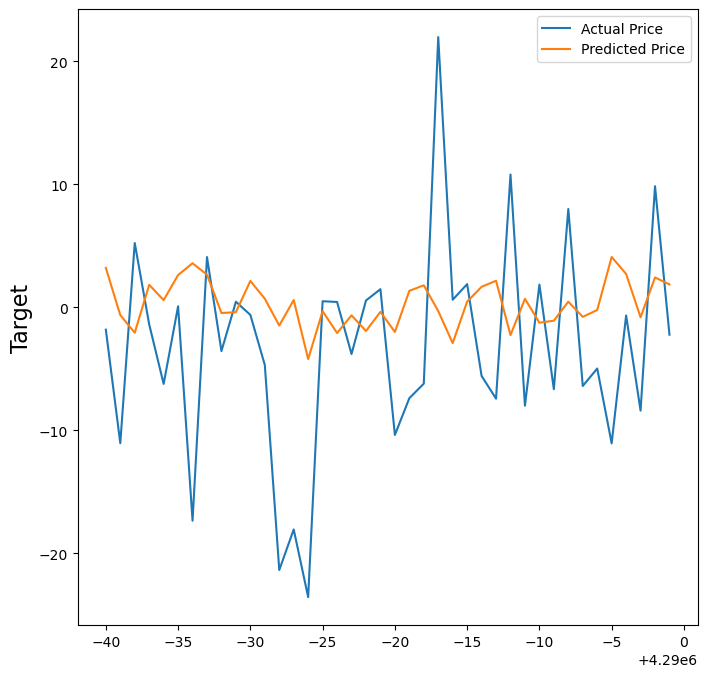

In [34]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe_train.tail(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<Axes: >

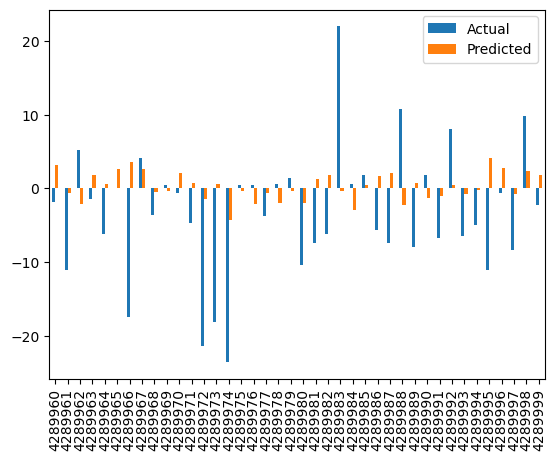

In [35]:
graph = dframe_train.tail(40)
graph.plot(kind='bar')

## Testing Metrics

In [22]:
dframe = pd.DataFrame({'Actual': y_test_true.values.flatten(), 'Predicted': y_test_pred.flatten()})
dframe

,Actual,Predicted
0,2.909899,-0.146188
1,-9.719729,1.540838
2,1.569986,0.535510
3,18.889904,-0.232363
4,3.089905,1.031995
...,...,...
978995,2.310276,-0.638383
978996,-8.220077,-0.722238
978997,1.169443,-0.422931
978998,-1.540184,-0.832911


In [24]:
print('Testing:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_true, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_true, y_test_pred))
print('Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test_true, y_test_pred)))

Testing:
Mean Absolute Error: 5.932363565777101
Mean Squared Error: 78.53721344413687
Root Mean Square Error: 8.862122400651938


## Presenting results with graphs

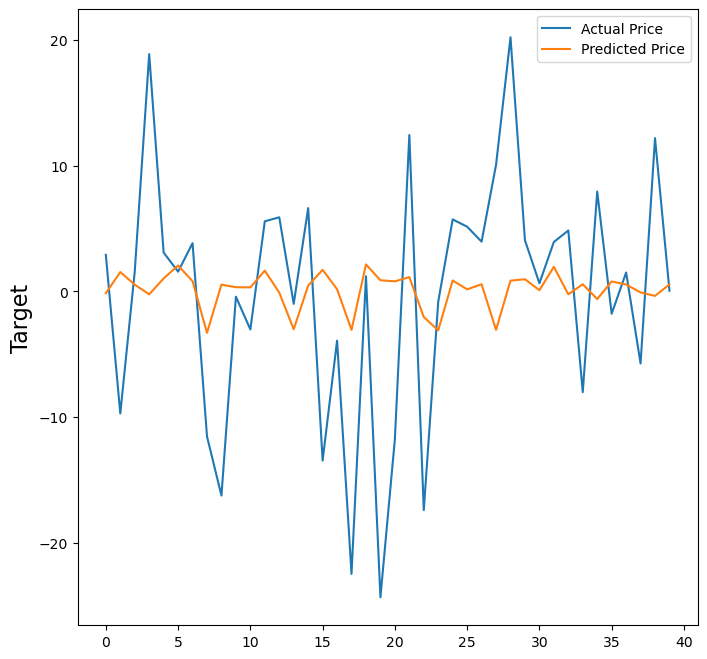

In [25]:
plt.figure(figsize=(8,8))
plt.ylabel('Target', fontsize=16)
plt.plot(dframe.head(40))
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

<Axes: >

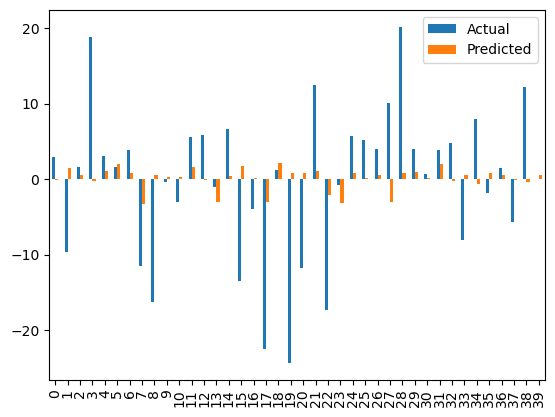

In [26]:
graph = dframe.head(40)
graph.plot(kind='bar')